<a href="https://colab.research.google.com/github/sdgroeve/Machine_Learning_course_UGent_D012554_2023/blob/main/notebooks/3_regularization/3%20regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# model regularization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style("whitegrid")

from sklearn import set_config
set_config(transform_output = "pandas")

In [2]:
###util methods
from sklearn import metrics
def plot_regression_degree(dataset,dataset_val,model,true_fun,degrees):	
    nrows  = len(degrees)/2.
    if int(nrows) < nrows:
        nrows = int(nrows)+1
    else:
        nrows = int(nrows)
    plt.figure(figsize=(12, 4*nrows))
    for i,d in enumerate(degrees):
        plt.subplot(nrows, 2, i+1)
        plt.subplots_adjust(hspace=.5)
        X = dataset.copy()
        X_test = pd.DataFrame(np.linspace(0, 1, 100),columns=['x1'])
        y = X.pop('y')
        X_val = dataset_val.copy()
        y_val = X_val.pop('y')
        for j in range(2,d+1):
            X['x1^'+str(j)] = X['x1']**j
            X_test['x1^'+str(j)] = X_test['x1']**j
            X_val['x1^'+str(j)] = X_val['x1']**j
        model.fit(X, y)
        pred = model.predict(X)
        pred_test = model.predict(X_test)
        pred_val = model.predict(X_val)
        plt.plot(X_test['x1'], pred_test, label="Model",lw=3)
        plt.plot(X_test['x1'], true_fun(X_test['x1']), label="True function")
        plt.scatter(X['x1'], y, label="train samples")
        plt.scatter(X_val['x1'], y_val, label="test samples",color="red")
        plt.xlabel("x1")
        plt.ylabel("y")
        plt.xlim((0, 1))
        plt.ylim((-2, 3))
        if i == 0: plt.legend(loc="upper right")
        plt.title("degree %d (%.3f,%.3f)" % (d,metrics.r2_score(y,pred),metrics.r2_score(y_val,pred_val)))
    plt.show()
def plot_coefs(lambdas,coefs):
    ax = plt.gca()
    ax.set_prop_cycle('color',['b', 'r', 'g', 'c', 'k', 'y', 'm'])
    ax.plot(lambdas, coefs)
    lineObjects = ax.plot(lambdas, coefs)
    ax.set_xscale('log')	
    plt.legend(iter(lineObjects),[r"$\theta_{" + s + "}$" for s in map(str,range(1,13))])
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\theta$')	  

## noise 

Real world data sets suffer from many shortcomings. The most important one is the presence of **noise**, which manifests itself at different levels:

- **noise in the feature values**: the true (underlying) feature values differ from the observed values in the data set. This typically happens when feature values are obtained from measuring devices such as microarrays or mass-spectrometers.

- **label noise**: the true underlying target or label for a data point is different from the one observed in the data set. This can happen, for instance, when a data set is manually labeled by a field expert (e.g. for the recognition of malignant melanoma). The expert can be wrong for some of the samples. Also, different experts may judge samples differently. 

- **redundant** or **irrelevant** features: redundant features are those which provide no more information than other features in the data set, and irrelevant features provide no useful information for the prediction task.

In the **presence of noise the model should not try to fit the data perfectly**. If it does it will be fitting the noise. This is known as **overfitting**.

Let's illustrate this with a simple polynomial regression example. We generate a data sets `dataset_reg` and `dataset_reg_test` that each contain 30 data points randomly sampled from function $f(x)=\cos(1.5\pi x)$. We add random noise to the target.

The set `dataset_reg` (the **training set**) will be used for fitting the linear model. The set `dataset_reg_test` (the **test set** will be used to evaluate the fitted model.

We plot the results for polynomial data transformations of varying degrees:

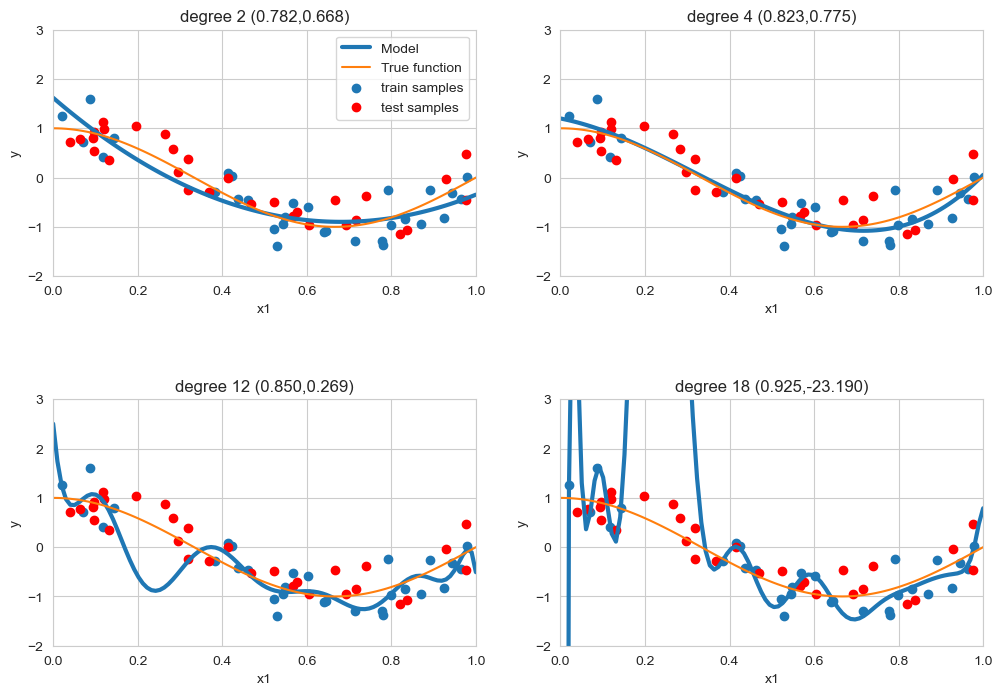

In [3]:
from sklearn.linear_model import LinearRegression

np.random.seed(0)

n_samples = 30

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

dataset_reg = pd.DataFrame()
dataset_reg['x1'] = np.sort(np.random.rand(n_samples))
dataset_reg['y'] = true_fun(dataset_reg['x1']) + np.random.randn(n_samples) * 0.3 #adding noise

dataset_reg_test = pd.DataFrame()
dataset_reg_test['x1'] = np.sort(np.random.rand(n_samples))
dataset_reg_test['y'] = true_fun(dataset_reg_test['x1']) + np.random.randn(n_samples) * 0.3 #adding noise

model_reg = LinearRegression()
plot_regression_degree(dataset_reg,dataset_reg_test,model_reg,true_fun,[2, 4, 12, 18])

For each plot, the polynomial degree of the model is shown in the title, together with the $R^2$ computed from the the training and the test set. 

We observe how the training set $R^2$ becomes higher when we increase the degree of the polynomial transformation, i.e. when we increase the complexity of the model. However, we also observe very clearly how the complex models start to fit the noise in the training set and starts to deviate strongly from the true function that generated the data (the orange curve). This is also shown by the test set $R^2$ that starts te decrease after $d=4$.

## model regularization

The idea behind **model regularization** is to find a balance between the **complexity** of the model (**what the model is capable of learning**) and the ability of the model to fit the data accurately. 

We have seen that a non-linear model with polynomial degree up to 18 is too complex for the data set presented above.

For these types of more complex models we need a way to **regulate it's complexity**. We need to 'tune' complexity such that is sufficiently complex to learn the true underlying model, but not more complex than that to avoid overfitting.

Mathematically we can formalize **regularization** as an additional term to the loss function of the learning algorithm. 

For regularized linear regression we formulate the loss function as

$$ J(\theta)=\frac{1}{2n}\sum\limits_{i=1}^n(f(x^{(i)},\theta) - y^{(i)})^2 + \lambda \sum\limits_{j=1}^{m}\theta_j^2.$$

The term added to the cost function of linear regression is $\lambda \sum\limits_{j=1}^{n}\theta_j^2$, i.e. the sum of the squared weights multiplied by $\lambda$. 

Minimizing the cost function $J(\theta)$ thus means minimizing the magnitude of the errors made on the training set, while simultaneously minimizing the complexity of the model (by choosing small values for $\theta$, preferably zero). This contribution of the model complexity to the loss function is then controlled by **hyperparameter** $\lambda\geq0$. For **regularized linear regression** (or **Ridge regression**) the updates computed during the gradient descent iterations become 

$$\theta_0:=\theta_0-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_0^{(i)},$$

and for $j=1 \ldots m$

$$\theta_j:=\theta_j-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_j^{(i)}-\frac{\lambda}{m}\theta_j,$$

with 

$$f(x,\theta)=\theta_0x_0 + \theta_1x_1 + \theta_2x_2+...+\theta_mx_m.$$

For **regularized logistic regression** the loss function becomes

$$J(\theta)=-[\frac{1}{n}\sum\limits_{i=1}^ny^{(i)}log(f(x^{(i)},\theta))+(1-y^{(i)})log(1- f(x^{(i)},\theta))]+\frac{\lambda}{2m}\sum\limits_{j=1}^{m}\theta^2,$$

where $\lambda\geq0$ is again a hyperparameter that controls the balance between model training set accuracy and model complexity and is again set by the user. The updates computed during the gradient descent iterations are now

$$\theta_0:=\theta_0-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_0^{(i)},$$

and for $j=1 \ldots m$

$$\theta_j:=\theta_j-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_j^{(i)}-\frac{\lambda}{m}\theta_j,$$

with

$$f(x,\theta)=g(\theta_0x_0 + \theta_1x_1 + \theta_2x_2+...+\theta_mx_m).$$

The regularized linear regression algorithm is implemented as the `Ridge` module in scikit-learn. Here we create a Ridge model with $\lambda=0.001$ (note the $\lambda$ is provided as function parameter *alpha*).

In [4]:
from sklearn.linear_model import Ridge

model_ridge = Ridge(alpha=0.001)

Now we can copy the code we used for the regression data set discussed above and replace the `LinearRegression` object by the `Ridge` object.

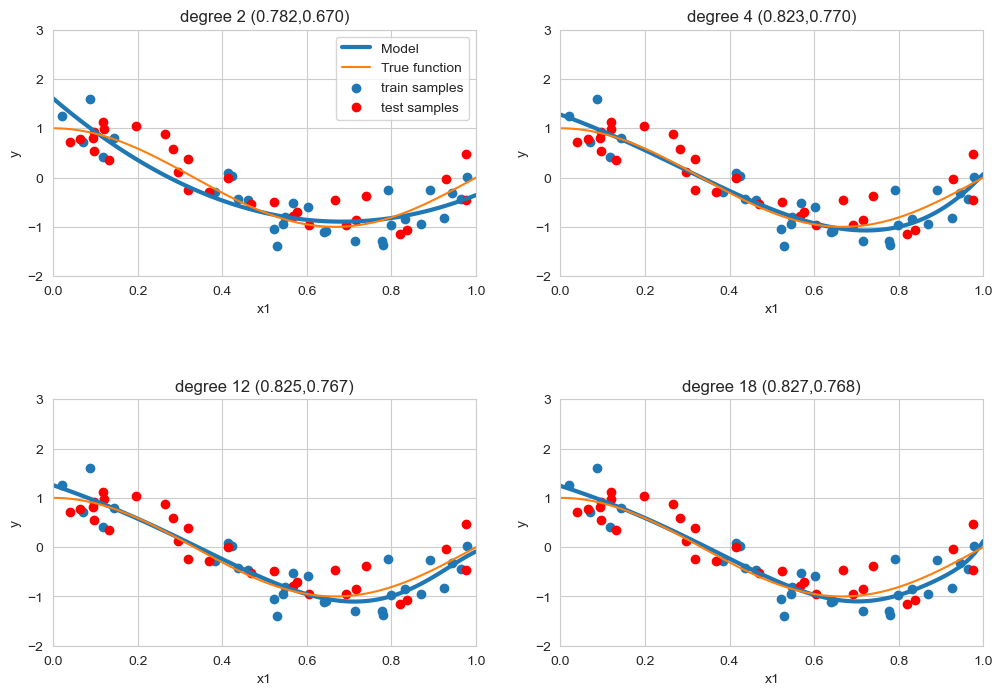

In [5]:
plot_regression_degree(dataset_reg,dataset_reg_test,model_ridge,true_fun,[2, 4, 12, 18])

Observe how the complexity of the model is controlled for the larger polynomial degrees. Let's take a look at the optimal model parameter values $\theta$ for the polynomial model of degree 12 when $\lambda=0.001$:

[-2.94383106e+00 -2.28257416e+00 -4.01816102e-01  1.52463524e+00
  2.20053436e+00  1.79557752e+00  8.95033922e-01 -1.30396812e-02
 -6.38933025e-01 -8.53642488e-01 -6.30129982e-01  2.77051400e-03]


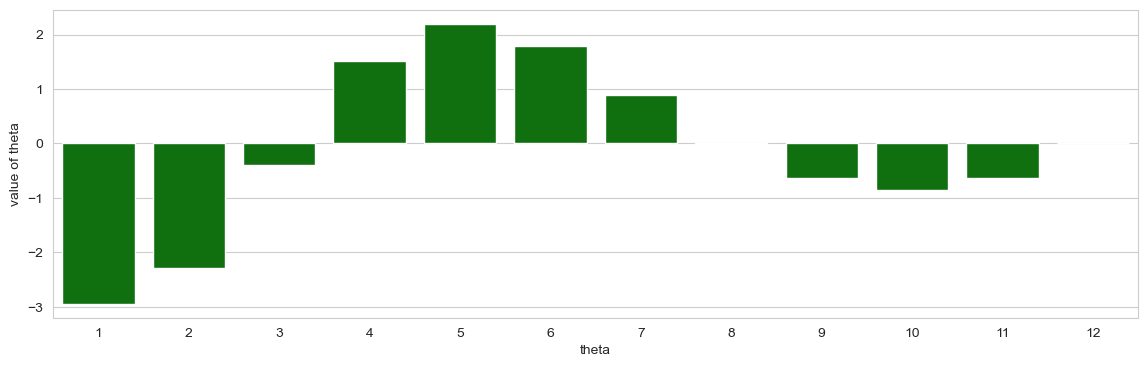

In [6]:
degree = 12

y_reg = dataset_reg.pop('y')
X_reg = dataset_reg

for j in range(2,degree+1):
    X_reg['x1^'+str(j)] = X_reg['x1']**j

model_ridge.fit(X_reg,y_reg)
coefs = model_ridge.coef_

print(coefs)

model_parameters = pd.DataFrame()
model_parameters['theta'] = range(1,len(coefs)+1)
model_parameters['value of theta'] = coefs

plt.figure(figsize=(14,4))
sns.barplot(x='theta',y='value of theta',data=model_parameters,color='g')
plt.show()

If we set $\lambda=0$, i.e. we remove the regularization term, we get the overfitting again:

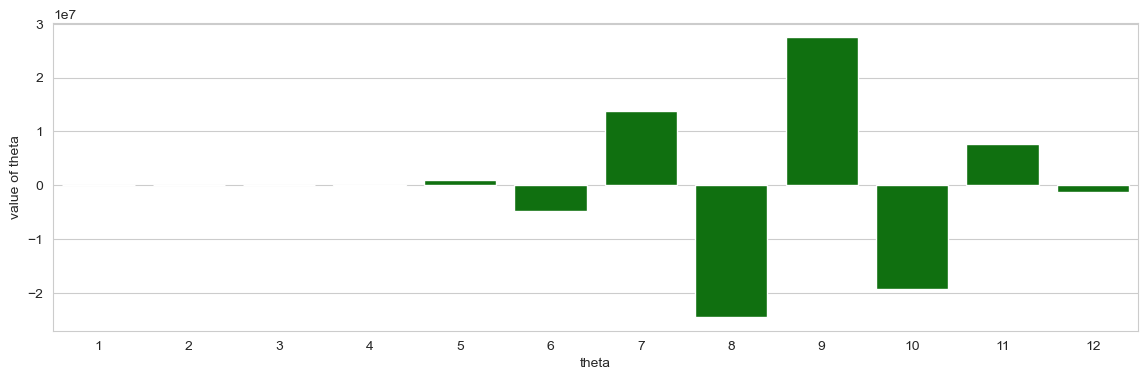

In [7]:
model_ridge = Ridge(alpha=0)

model_ridge.fit(X_reg,y_reg)
coefs = model_ridge.coef_

model_parameters = pd.DataFrame()
model_parameters['theta'] = range(1,len(coefs)+1)
model_parameters['value of theta'] = coefs

plt.figure(figsize=(14,4))
sns.barplot(x='theta',y='value of theta',data=model_parameters,color='g')
plt.show()

We can see that the values for $\theta$ are much larger now (notice that the scale of the y-axis is 1e7) and much more weight is assigned to the higher degree polynomial features.  This made it possible to fit more complex models that are able to fit the noise well. Regularization is thus closely related to the nature of the noise in the data set. Regularization is also related to the relative size of the dataset. Data sets with many features and few samples are common in Machine Learning and are easy to overfit. Regularization helps significantly to deal with these **sparse high-dimensional** data sets. 

For now we have chosen $\lambda=0.001$ as a good regulator. Let's consider other values for $\lambda$ and see how they affect the model parameters and the fit. 

We fit different Ridge models (with different values for $\lambda$) to the training set and plot the optimal values for $\theta$ against $\lambda$. Each model parameter $\theta_j$ is represented by a color: 

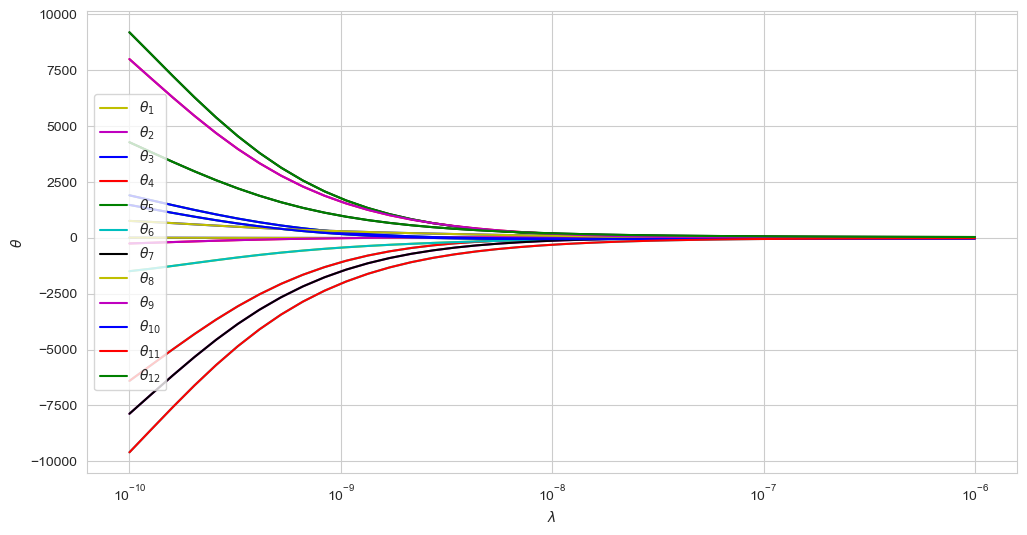

In [8]:
n_lambda = 40
lambdas = np.logspace(-6, -10, n_lambda)

model_ridge = Ridge()

coefs = []
for l in lambdas:
    model_ridge.set_params(alpha=l)
    model_ridge.fit(X_reg, y_reg)
    coefs.append(model_ridge.coef_)

plt.figure(figsize=(12,6))
plot_coefs(lambdas,coefs)
plt.show()    

The plot shows how larger values for $\lambda$ constrain the values the model parameters can have.

For regularized logistic regression we reconsider dataset `dataset_lin` and fit a regularized logistic regression model after adding polynomial features up to degree 7. 

We use the `LogisticRegression` module from scikit-learn that is in fact already an implementation of regularized logistic regression with hyperparameter $C$ controling the regularization. However in this implementation $C$ = $1/\lambda$, i.e. larger values for $C$ will allow for more complex models. 

Try running the code below with different values for $C$:

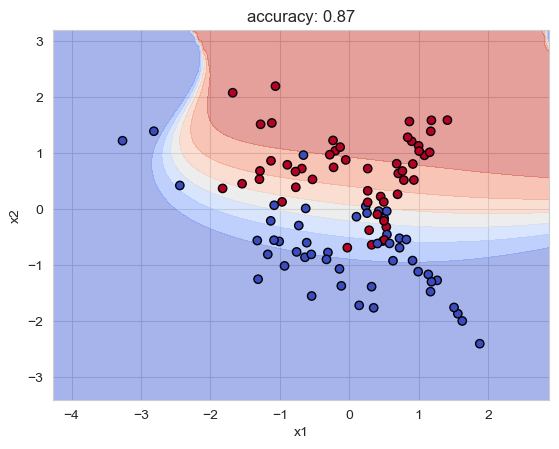

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay


dataset_lin = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/notebooks/3_logistic_regression/dataset2D.csv")

X = dataset_lin.loc[:,dataset_lin.columns!="y"]
y = dataset_lin.loc[:,"y"]

feature_scaler = MinMaxScaler()

clf = LogisticRegression(C=10)
polynomial_features = PolynomialFeatures(degree=18)
model_pipeline = Pipeline([("polynomial_features", polynomial_features),
                           ("MinMaxScaler", feature_scaler),
                         ("logistic_regression", clf)])

model_pipeline.fit(X,y)

disp = DecisionBoundaryDisplay.from_estimator(model_pipeline, 
                                              X, 
                                              response_method="predict_proba",
                                              xlabel=X.columns[0], ylabel=X.columns[1],
                                              alpha=0.5, 
                                              cmap=plt.cm.coolwarm)

# Plotting the data points    
disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], 
                 c=y, edgecolor="k",
                 cmap=plt.cm.coolwarm)

plt.title("accuracy: %.2f"%model_pipeline.score(X,y))
plt.show()

We now have a means to control the complexity of the model learned from the train set by setting the value of a reglurization hyperparameter that controls the **complexity of the model**. 